In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [22]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import defaultdict
import seaborn as sns
import pandas as pd

In [3]:
# configure matplotlib
%matplotlib notebook
# %matplotlib inline

In [4]:
#mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rc('font',**{'family':'serif'})
mpl.rc('text', usetex=True)
mpl.rcParams['text.latex.preamble']=r"\usepackage{amsmath}"

In [14]:
from cdi.util.analysis.plotting import plot_comparison, barplot_comparison, HandlerTupleVertical
from cdi.util.analysis.eval import (compute_avg_loglikelihood_w_std_err,
                                    compute_param_error,
                                    compute_avg_test_loglikelihood_vs_train_time)
from cdi.util.stats_utils import load_statistics
from cdi.data.uci_gas import GasDataset

## Analysis setup

### Global settings

In [6]:
data_name = 'flows_uci'
flow_data = 'gas'
# exp_seed_key = 'm20190508_d20200325_20200406_20200407'
exp_seed_keys = [
    'm20190508_d20200325_20200406_20200407',
#     'm2019050811_d2020032511_20200406_20200407',
#     'm2019050822_d2020032522_20200406_20200407',
#     'm2019050833_d2020032533_20200406_20200407',
#     'm2019050844_d2020032544_20200406_20200407',
]

### Templates

In [15]:
log_path_template = f'../../trained_models/{data_name}/learning_experiments/{{}}/{{}}/{{}}/logs/{{}}'
log_path_base = f'../../trained_models/{data_name}/learning_experiments'

eval_path_template = f'../../trained_models/{data_name}/learning_experiments/{{}}/{{}}/{{}}/evaluations/tensors/{{}}'


## Helpers

In [8]:
def read_experiment_stats(group, model, seed, filename):
    path = log_path_template.format(group, model, seed, filename)
    filename = os.path.basename(path)
    dirpath = os.path.dirname(path)
    try:
        return load_statistics(dirpath, filename)
    except FileNotFoundError:
        warnings.warn(f'File {dirpath} not found, ignoring.')
        return defaultdict(lambda: float('nan'))

def read_experiment_stats_val(group, model, seed, val_ckpt, filename):
    path = log_path_template_val.format(group, model, seed, val_ckpt, filename)
    filename = os.path.basename(path)
    dirpath = os.path.dirname(path)
    try:
        return load_statistics(dirpath, filename)
    except FileNotFoundError:
        warnings.warn(f'File {dirpath} not found, ignoring.')
        return defaultdict(lambda: float('nan'))

def read_experiment_stats_all_seeds(group, model, filename):
    all_stats = defaultdict(list)
    for exp_seed in exp_seed_keys:
        path = log_path_template.format(group, model, exp_seed, filename)
        filename = os.path.basename(path)
        dirpath = os.path.dirname(path)
        stats = load_statistics(dirpath, filename)
        for k, v in stats.items():
            all_stats[k].append(v)
    
    return all_stats

def read_suite_stats_all_seeds(group, suite, filename):
    return {
        name: read_experiment_stats_all_seeds(group, model, filename)
        for name, model in suite.items()
    }

def read_suite_stats(group, suite, filename, seed):
    return {
        name: read_experiment_stats(group, model, seed, filename)
        for name, model in suite.items()
    }

def read_suite_stats_val(group, suite, filename, val_ckpts, seed):
    stats = {}
    for name, model in suite.items():
        for ckpt in val_ckpts[name]:
            name_i = f'{name} val{ckpt}'
            ckpt_name = f'{ckpt}_cust'
            try:
                stats[name_i] = read_experiment_stats_val(group, model, seed, ckpt_name, filename)
            except FileNotFoundError as err:
#                 print('Error:', err)
                continue
    return stats

def read_suite_stats_val2(group, suite, filename, val_ckpts, seed):
    stats = {}
    for name, model in suite.items():
        stats_i = defaultdict(list)
        for ckpt in val_ckpts[name]:
            try:
                ckpt_name = f'{ckpt}_cust'
                stat = read_experiment_stats_val(group, model, seed, ckpt_name, filename)
                for k, v in stat.items():
                    # Append the last element from each key
                    stats_i[k].append(v[-1])
                stats_i['epoch'].append(ckpt)
            except FileNotFoundError as err:
#                 print('Error:', err)
                continue
        stats[name] = stats_i
    return stats

def read_suite_stats_with_init_all_seeds(group, suite):
    stats = {}
    for name, model in suite.items():
        stats[name] = read_experiment_stats_all_seeds(group, model, 'summary.csv')
        # Please ignore this ugliness it just appends the initialisation stats to the experiment stats
        if os.path.exists(log_path_template.format(group, model, exp_seed_keys[0], 'init_summary.csv')):
            init_stats = read_experiment_stats_all_seeds(group, model, 'init_summary.csv')
            stats[name]['init'] = init_stats

    return stats

def read_suite_stats_with_init(group, suite, seed):
    stats = {}
    for name, model in suite.items():
        stats[name] = read_experiment_stats(group, model, seed, 'summary.csv')
        # Please ignore this ugliness it just appends the initialisation stats to the experiment stats
        if os.path.exists(log_path_template.format(group, model, seed, 'init_summary.csv')):
            init_stats = read_experiment_stats(group, model, seed, 'init_summary.csv')
            stats[name]['init'] = init_stats

    return stats

##

def read_all_suite_stats(groups, suite, filename, seed):
    return {
        group: read_suite_stats(group, suite, filename, seed)
        for group in groups
    }


def ma(a, ws=10):
    return np.convolve(a[::-1], np.ones(ws)/ws, mode='valid')[::-1]

In [9]:
# ggplot
colors = ['#000000', '#E24A33', '#988ED5', '#34b9bd', '#FBC15E', '#348ABD', '#FFB5B8', '#777777', '#8EBA42',]

## Generative model analysis

### Log-likelihood analysis

For each method train a number of models using the same complete dataset but different missingness generated by changing only the random seed for the missingness generator. The fitted models are then used to compute fully-observed average log-likelihood on a held-out test dataset. Finally, the results from different seeds are averaged and standard error is computed.

In [10]:
suite_line = {
    'RQ-Flow (Complete)': f'rqcspline_{flow_data}_complete_data',
}

suite_subsampled = {
    'RQ-Flow (Subsampled)': f'rqcspline_{flow_data}_complete_data_subsampled'
}


suite_bar = {
    'VGI': f'rqcspline_{flow_data}_chrqsvar_cdi_uncondgauss',
    'PLMCMC': f'rqcspline_{flow_data}_plmcmc',
}
# groups = [1, 2, 3, 4, 5]
groups = [1, 3, 5]

<IPython.core.display.Javascript object>


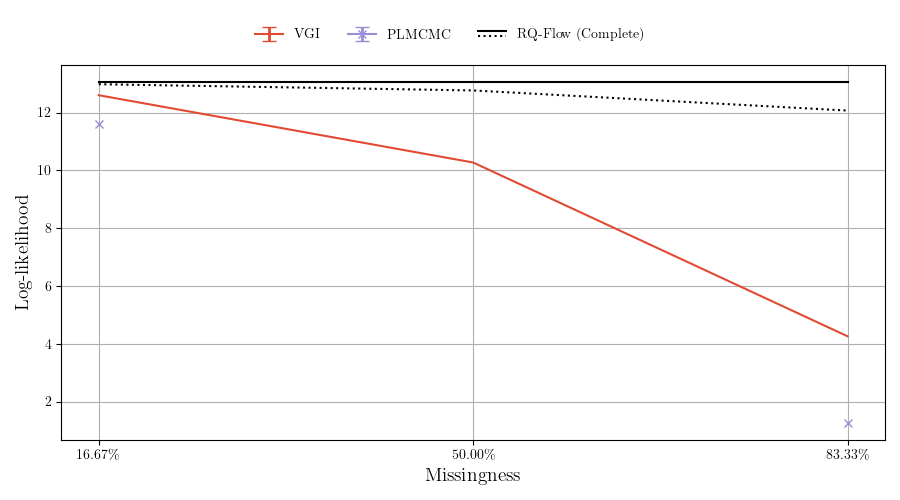

RQ-Flow (Complete) None [13.055319786071777, 13.055319786071777, 13.055319786071777] [False False False]
VGI None [12.59998607635498, 10.272557258605957, 4.261804580688477] [False False False]
PLMCMC x [11.592916488647461, nan, 1.2571953535079956] [False  True False]
RQ-Flow (Subsampled) None [12.980537414550781, 12.765146255493164, 12.068878173828125] [False False False]


/home/vaidas/Projects/cumulative-data-imputation/cdi/util/analysis/eval.py:34: UserWarning: File ../../trained_models/flows_uci/learning_experiments/3/rqcspline_gas_plmcmc/m20190508_d20200325_20200406_20200407/evaluations/tensors/data_log_probs_test.npz not found, ignoring.
  warnings.warn(f'File {path} not found, ignoring.')


In [13]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(9, 5))
# axes.set(title=f'Test log-likelihood')

stats_line = {}
# Load stats for every experiment in the suite
for exp_name, model_name in suite_line.items():
    stats_line[exp_name] = compute_avg_loglikelihood_w_std_err(model_name, 
                                                               seeds=exp_seed_keys,
                                                               groups=groups,
                                                               base_path=log_path_base)
plot_comparison(axes, stats_line,
                x_metric_key='group',
                y_metric_keys=('test_log_lik',),  
                err_keys=('test_log_lik_stderr',),
                xlabel='Missingness',
                ylabel='Log-likelihood', 
                colors=colors,
#                 ylim=(450, 1200))
               )
    
stats_bar = {}
# Load stats for every experiment in the suite
for exp_name, model_name in suite_bar.items():
    stats_bar[exp_name] = compute_avg_loglikelihood_w_std_err(model_name, 
                                                              seeds=exp_seed_keys,
                                                              groups=groups,
                                                              base_path=log_path_base,
                                                              ignore_notfound=True)

# barplot_comparison(axes, stats_bar, width=0.09,
#                     x_metric_key='group',
#                     y_metric_keys=('test_log_lik',),  
#                     err_keys=('test_log_lik_stderr',),
#                     xlabel='Missingness',
#                     ylabel='Log-likelihood', 
#                     colors=colors[1:],
# #                     edgecolors=[None, 'red'] + [None]*(len(colors)-3),
# #                     ylim=(450, 1200),
#                       gap=0.03, gap_idxs=[2]
#                   )
plot_comparison(axes, stats_bar, 
                x_metric_key='group',
                y_metric_keys=('test_log_lik',),  
                err_keys=('test_log_lik_stderr',),
                xlabel='Missingness',
                ylabel='Log-likelihood', 
                colors=colors[1:],
                ylim=None)

# for exp, model_name in suite_subsampled.items():
#     stat_sub = compute_avg_loglikelihood_w_std_err(model_name, 
#                                                    seeds=exp_seed_keys,
#                                                    groups=groups,
#                                                    base_path=log_path_base)
    
#     for g in range(len(stat_sub['group'])):
#         axes.hlines(stat_sub['test_log_lik'], 
#                     xmin=np.array(stat_sub['group'])-0.5, 
#                     xmax=np.array(stat_sub['group'])+0.5,
#                     linestyles=[':'],
#                     colors=colors[:1])

stat_sub = {}
for exp, model_name in suite_subsampled.items():
    stat_sub[exp] = compute_avg_loglikelihood_w_std_err(model_name, 
                                                   seeds=exp_seed_keys,
                                                   groups=groups,
                                                   base_path=log_path_base)
    
plot_comparison(axes, stat_sub, 
                x_metric_key='group',
                y_metric_keys=('test_log_lik',),  
                err_keys=('test_log_lik_stderr',),
                xlabel='Missingness',
                ylabel='Log-likelihood', 
                colors=colors[:1],
                styles=[':'],
                ylim=None)

axes.set_xticks(groups)
axes.set_xticklabels(list(f'{g/6*100:.2f}\\%' for g in groups))

# axes.grid()

fig.tight_layout(rect=(0, 0, 1, 0.90))

handles, labels = axes.get_legend_handles_labels()

handles = handles[1:-1] + [(mpl.lines.Line2D([0], [0], color=colors[0], linestyle='-'), 
                          mpl.lines.Line2D([0], [0], color=colors[0], linestyle=':'))]
labels = labels[1:-1] + labels[:1]

axes.legend(handles, labels,
            ncol=3, bbox_to_anchor=(0.5, 0.93), bbox_transform=fig.transFigure, loc='center', 
            frameon=False,
            handler_map = {tuple : HandlerTupleVertical()})

In [15]:
# fig.savefig('figures/rqcspline_gas_test_loglik.pdf', bbox_inches='tight')

### Qualitative

#### Correlation

<IPython.core.display.Javascript object>


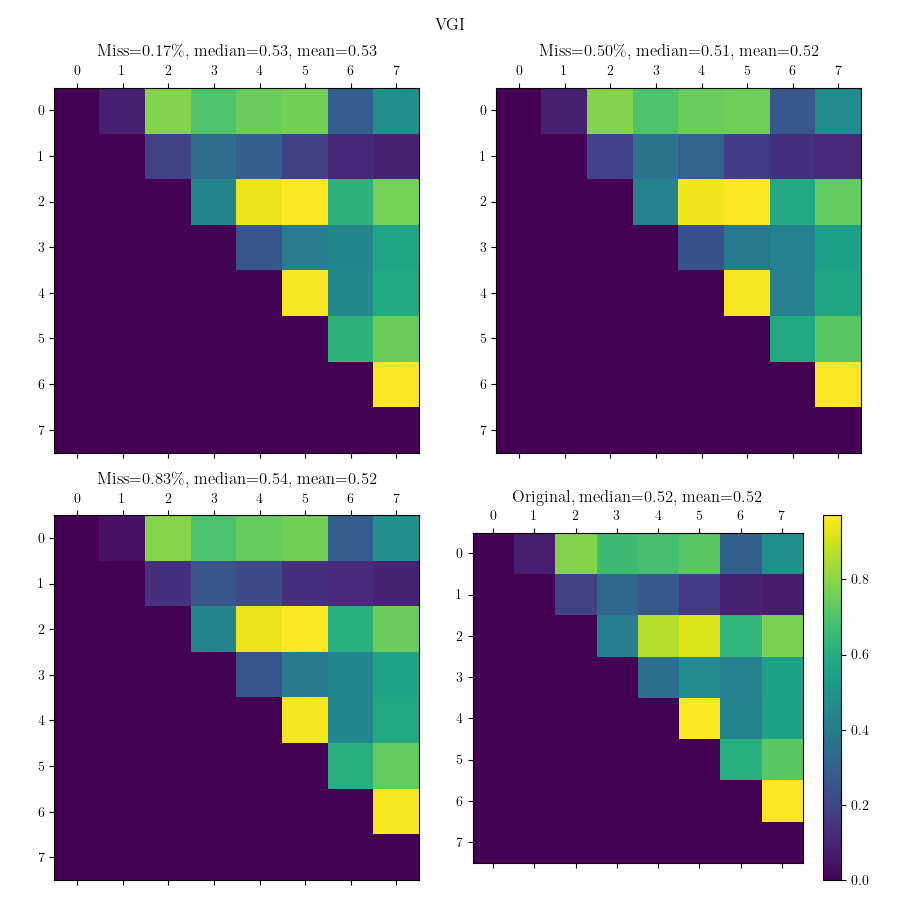

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 9))
axes = axes.flatten()

groups = [1,3,5]
method = f'rqcspline_{flow_data}_chrqsvar_cdi_uncondgauss'
for i, g in enumerate(groups):
    try:
        path = eval_path_template.format(g, 
                                         method, 
                                         exp_seed_keys[0], 
                                         'flow_samples_test.npz')
        samples = np.load(path)

        corrmat = np.corrcoef(samples['samples'], rowvar=False)
        abs_corrmat = np.abs(corrmat)
        triang_indices = np.triu_indices_from(corrmat, k=1)
        median = np.median(abs_corrmat[triang_indices])
        mean = np.mean(abs_corrmat[triang_indices])
        
        idx = np.tril_indices_from(corrmat, k=0)
        abs_corrmat[idx] = 0

        axes[i].matshow(abs_corrmat, interpolation='nearest')

        axes[i].set_title(f'Miss={g/6:.2f}\%, {median=:.2f}, {mean=:.2f}')
    except FileNotFoundError:
        axes[i].set_title(f'Miss={g/6:.2f}\%, median=-, mean=-')

dataset = GasDataset(root='../../data', split='train')

corrmat = np.corrcoef(dataset.data, rowvar=False)
abs_corrmat = np.abs(corrmat)
triang_indices = np.triu_indices_from(corrmat, k=1)
median = np.median(abs_corrmat[triang_indices])
mean = np.mean(abs_corrmat[triang_indices])

idx = np.tril_indices_from(corrmat, k=0)
abs_corrmat[idx] = 0

cax = axes[-1].matshow(abs_corrmat, interpolation='nearest')

axes[-1].set_title(f'Original, {median=:.2f}, {mean=:.2f}')  

fig.suptitle('VGI')


fig.tight_layout()
fig.colorbar(cax)


<IPython.core.display.Javascript object>


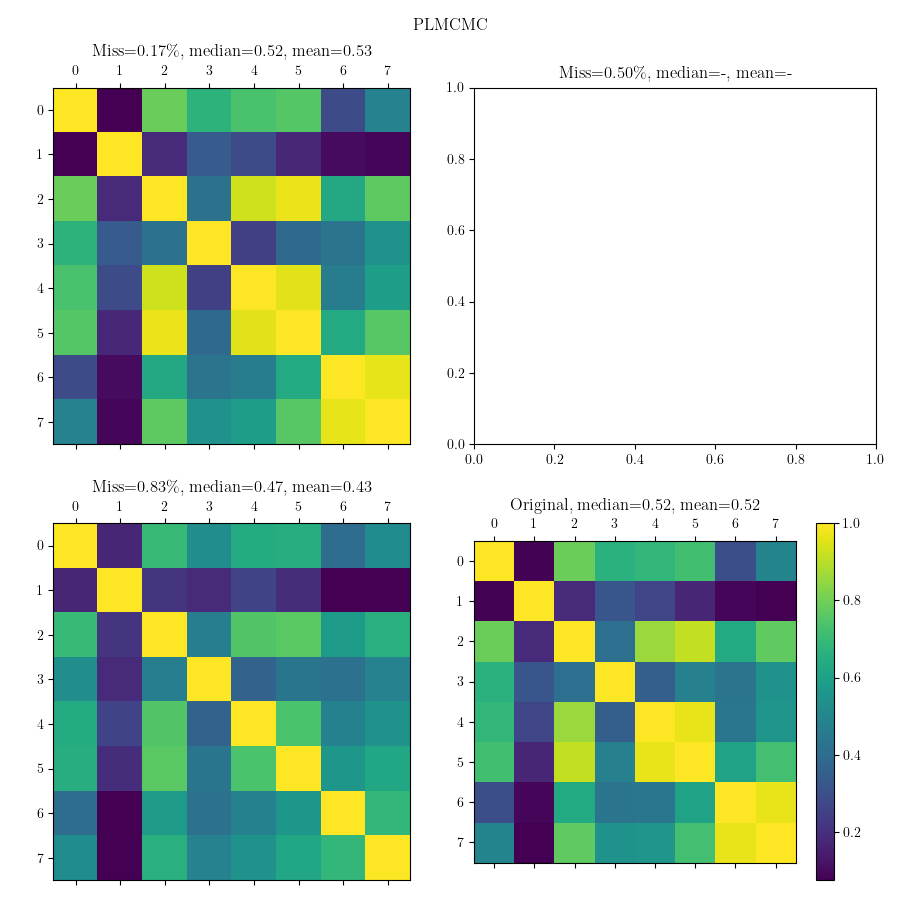

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 9))
axes = axes.flatten()

groups = [1,3,5]
method = f'rqcspline_{flow_data}_plmcmc'
for i, g in enumerate(groups):
    try:
        path = eval_path_template.format(g, 
                                         method, 
                                         exp_seed_keys[0], 
                                         'flow_samples_test.npz')
        samples = np.load(path)

        corrmat = np.corrcoef(samples['samples'], rowvar=False)
        abs_corrmat = np.abs(corrmat)
        triang_indices = np.triu_indices_from(corrmat, k=1)
        median = np.median(abs_corrmat[triang_indices])
        mean = np.mean(abs_corrmat[triang_indices])

        axes[i].matshow(abs_corrmat, interpolation='nearest')

        axes[i].set_title(f'Miss={g/6:.2f}\%, {median=:.2f}, {mean=:.2f}')
    except FileNotFoundError:
        axes[i].set_title(f'Miss={g/6:.2f}\%, median=-, mean=-')

dataset = GasDataset(root='../../data', split='train')

corrmat = np.corrcoef(dataset.data, rowvar=False)
abs_corrmat = np.abs(corrmat)
triang_indices = np.triu_indices_from(corrmat, k=1)
median = np.median(abs_corrmat[triang_indices])
mean = np.mean(abs_corrmat[triang_indices])

cax = axes[-1].matshow(abs_corrmat, interpolation='nearest')

axes[-1].set_title(f'Original, {median=:.2f}, {mean=:.2f}')  

fig.suptitle('PLMCMC')


fig.tight_layout()
fig.colorbar(cax)


#### Pairplot

<IPython.core.display.Javascript object>


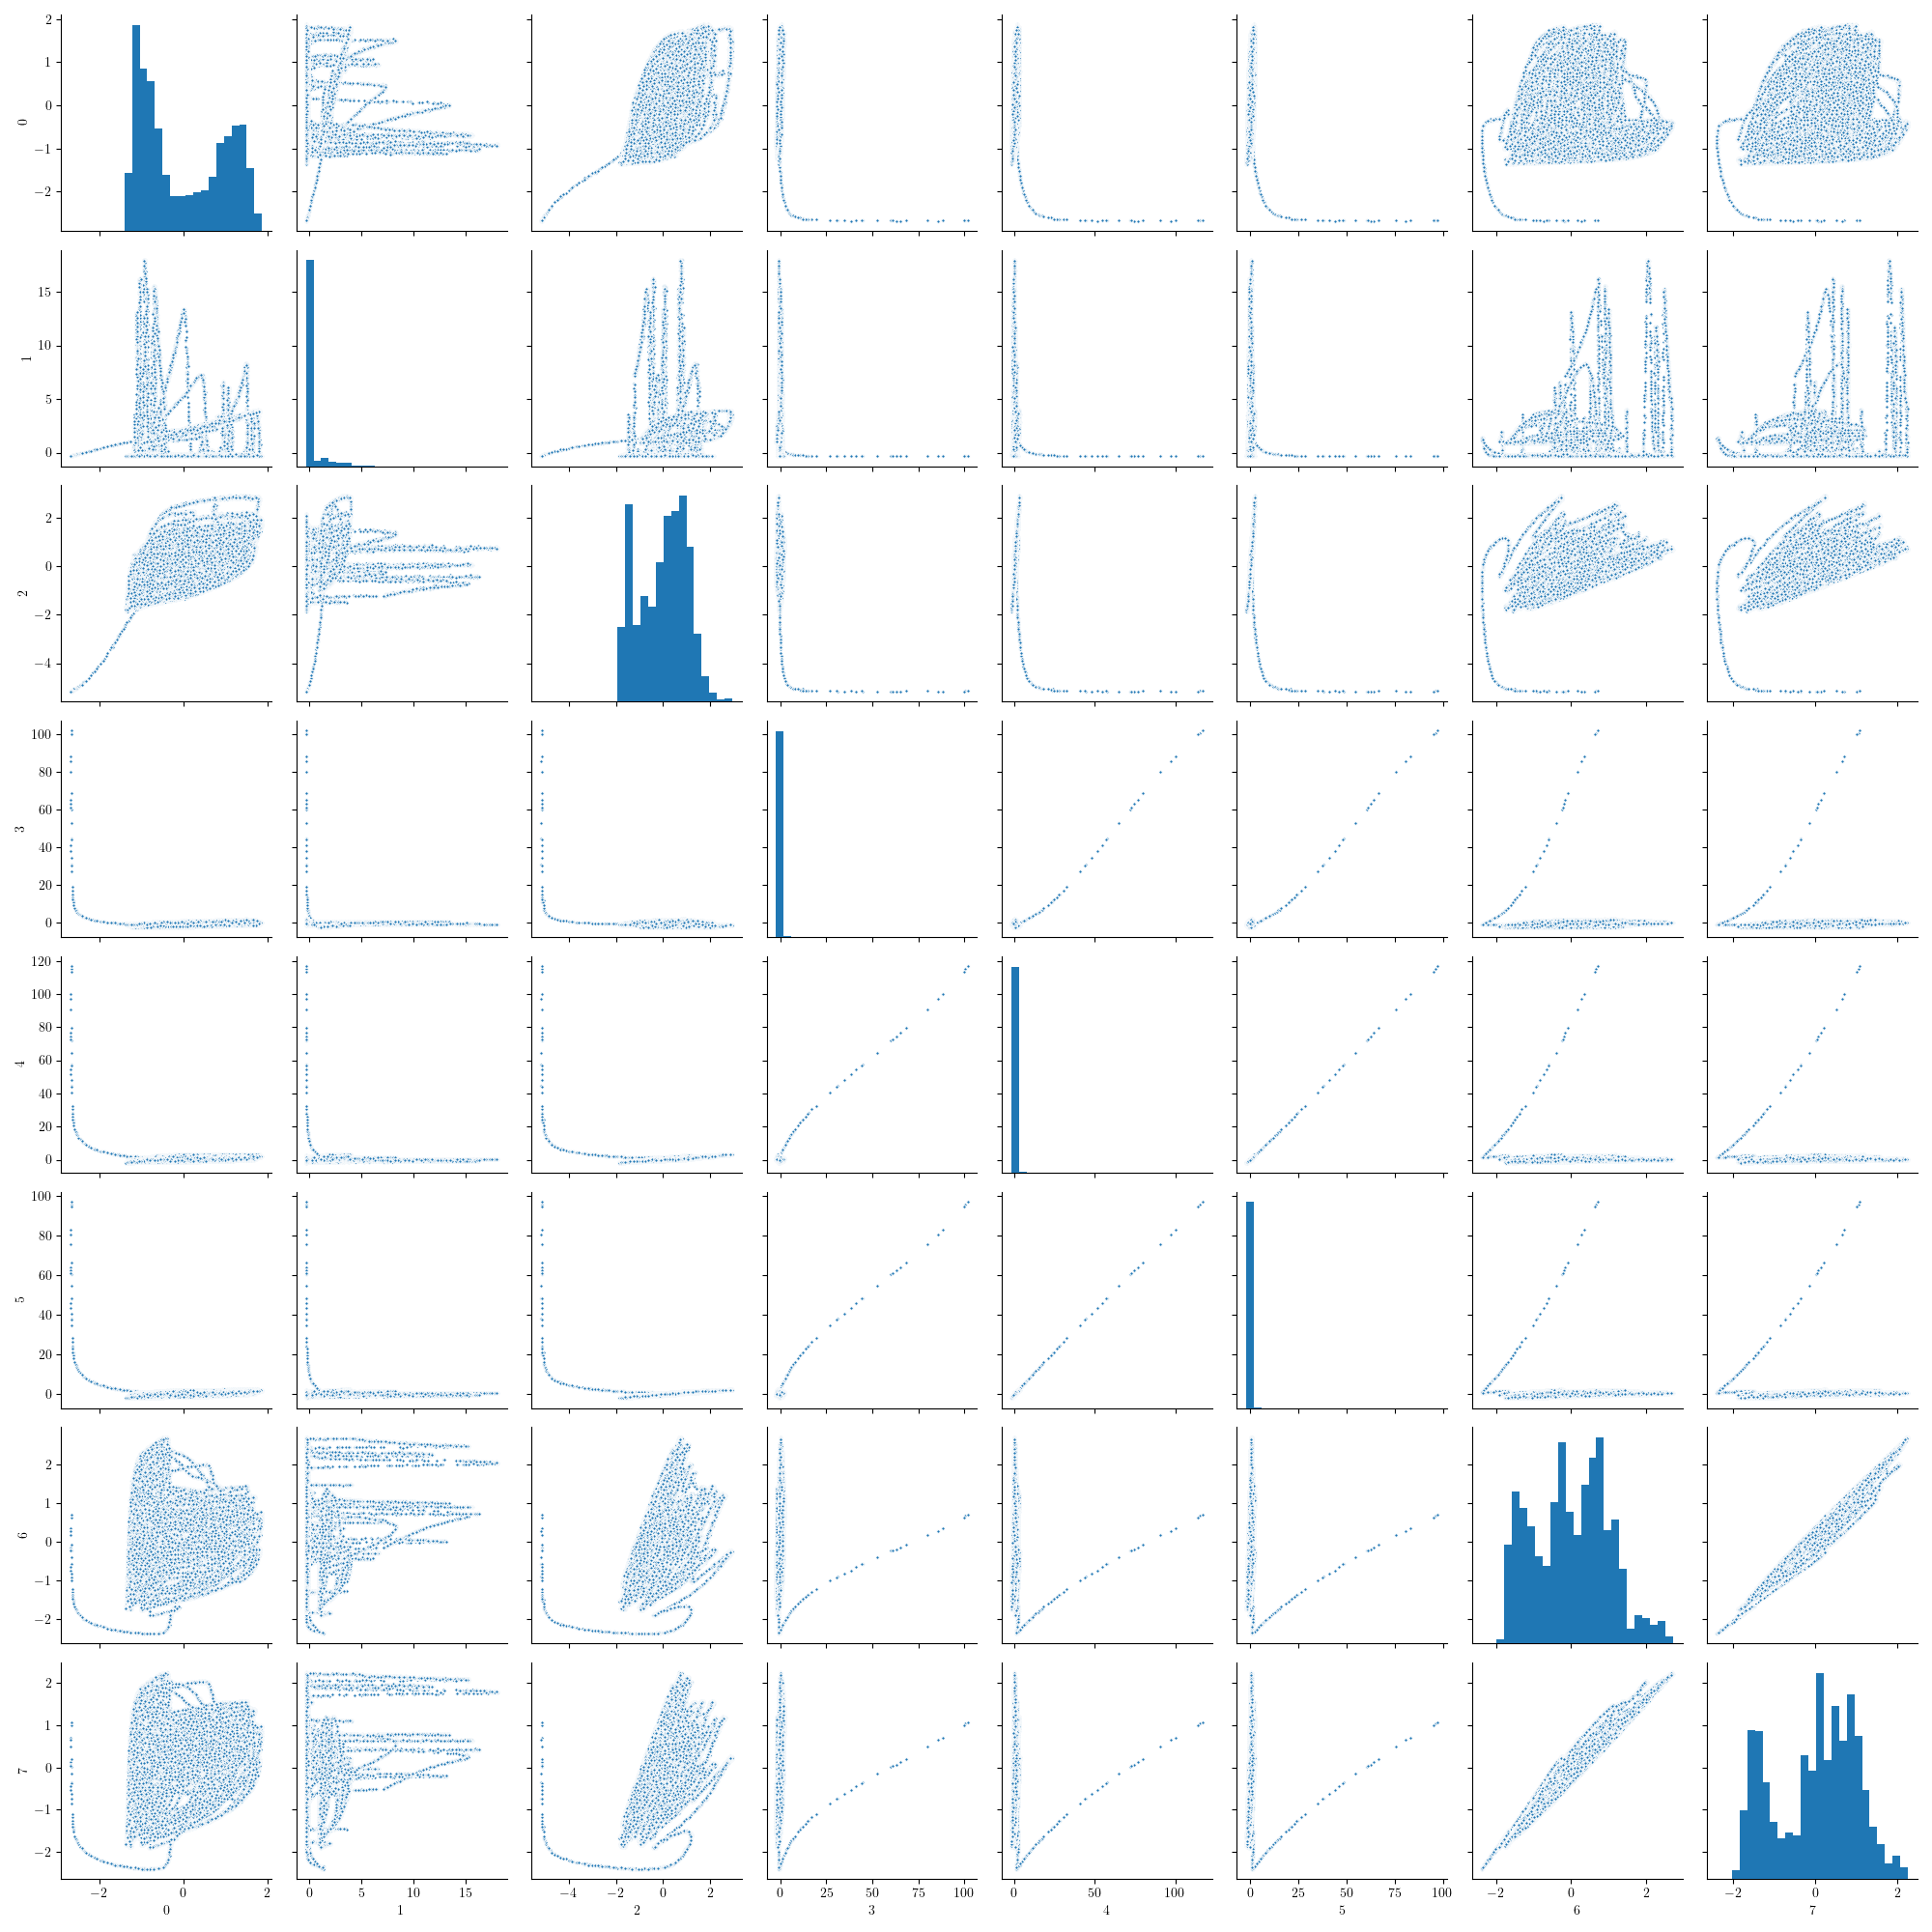

In [24]:
## Original

dataset = GasDataset(root='../../data', split='train')

sns.pairplot(pd.DataFrame(dataset.data),
             plot_kws={'s': 6},
             diag_kws={'bins': 25})

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


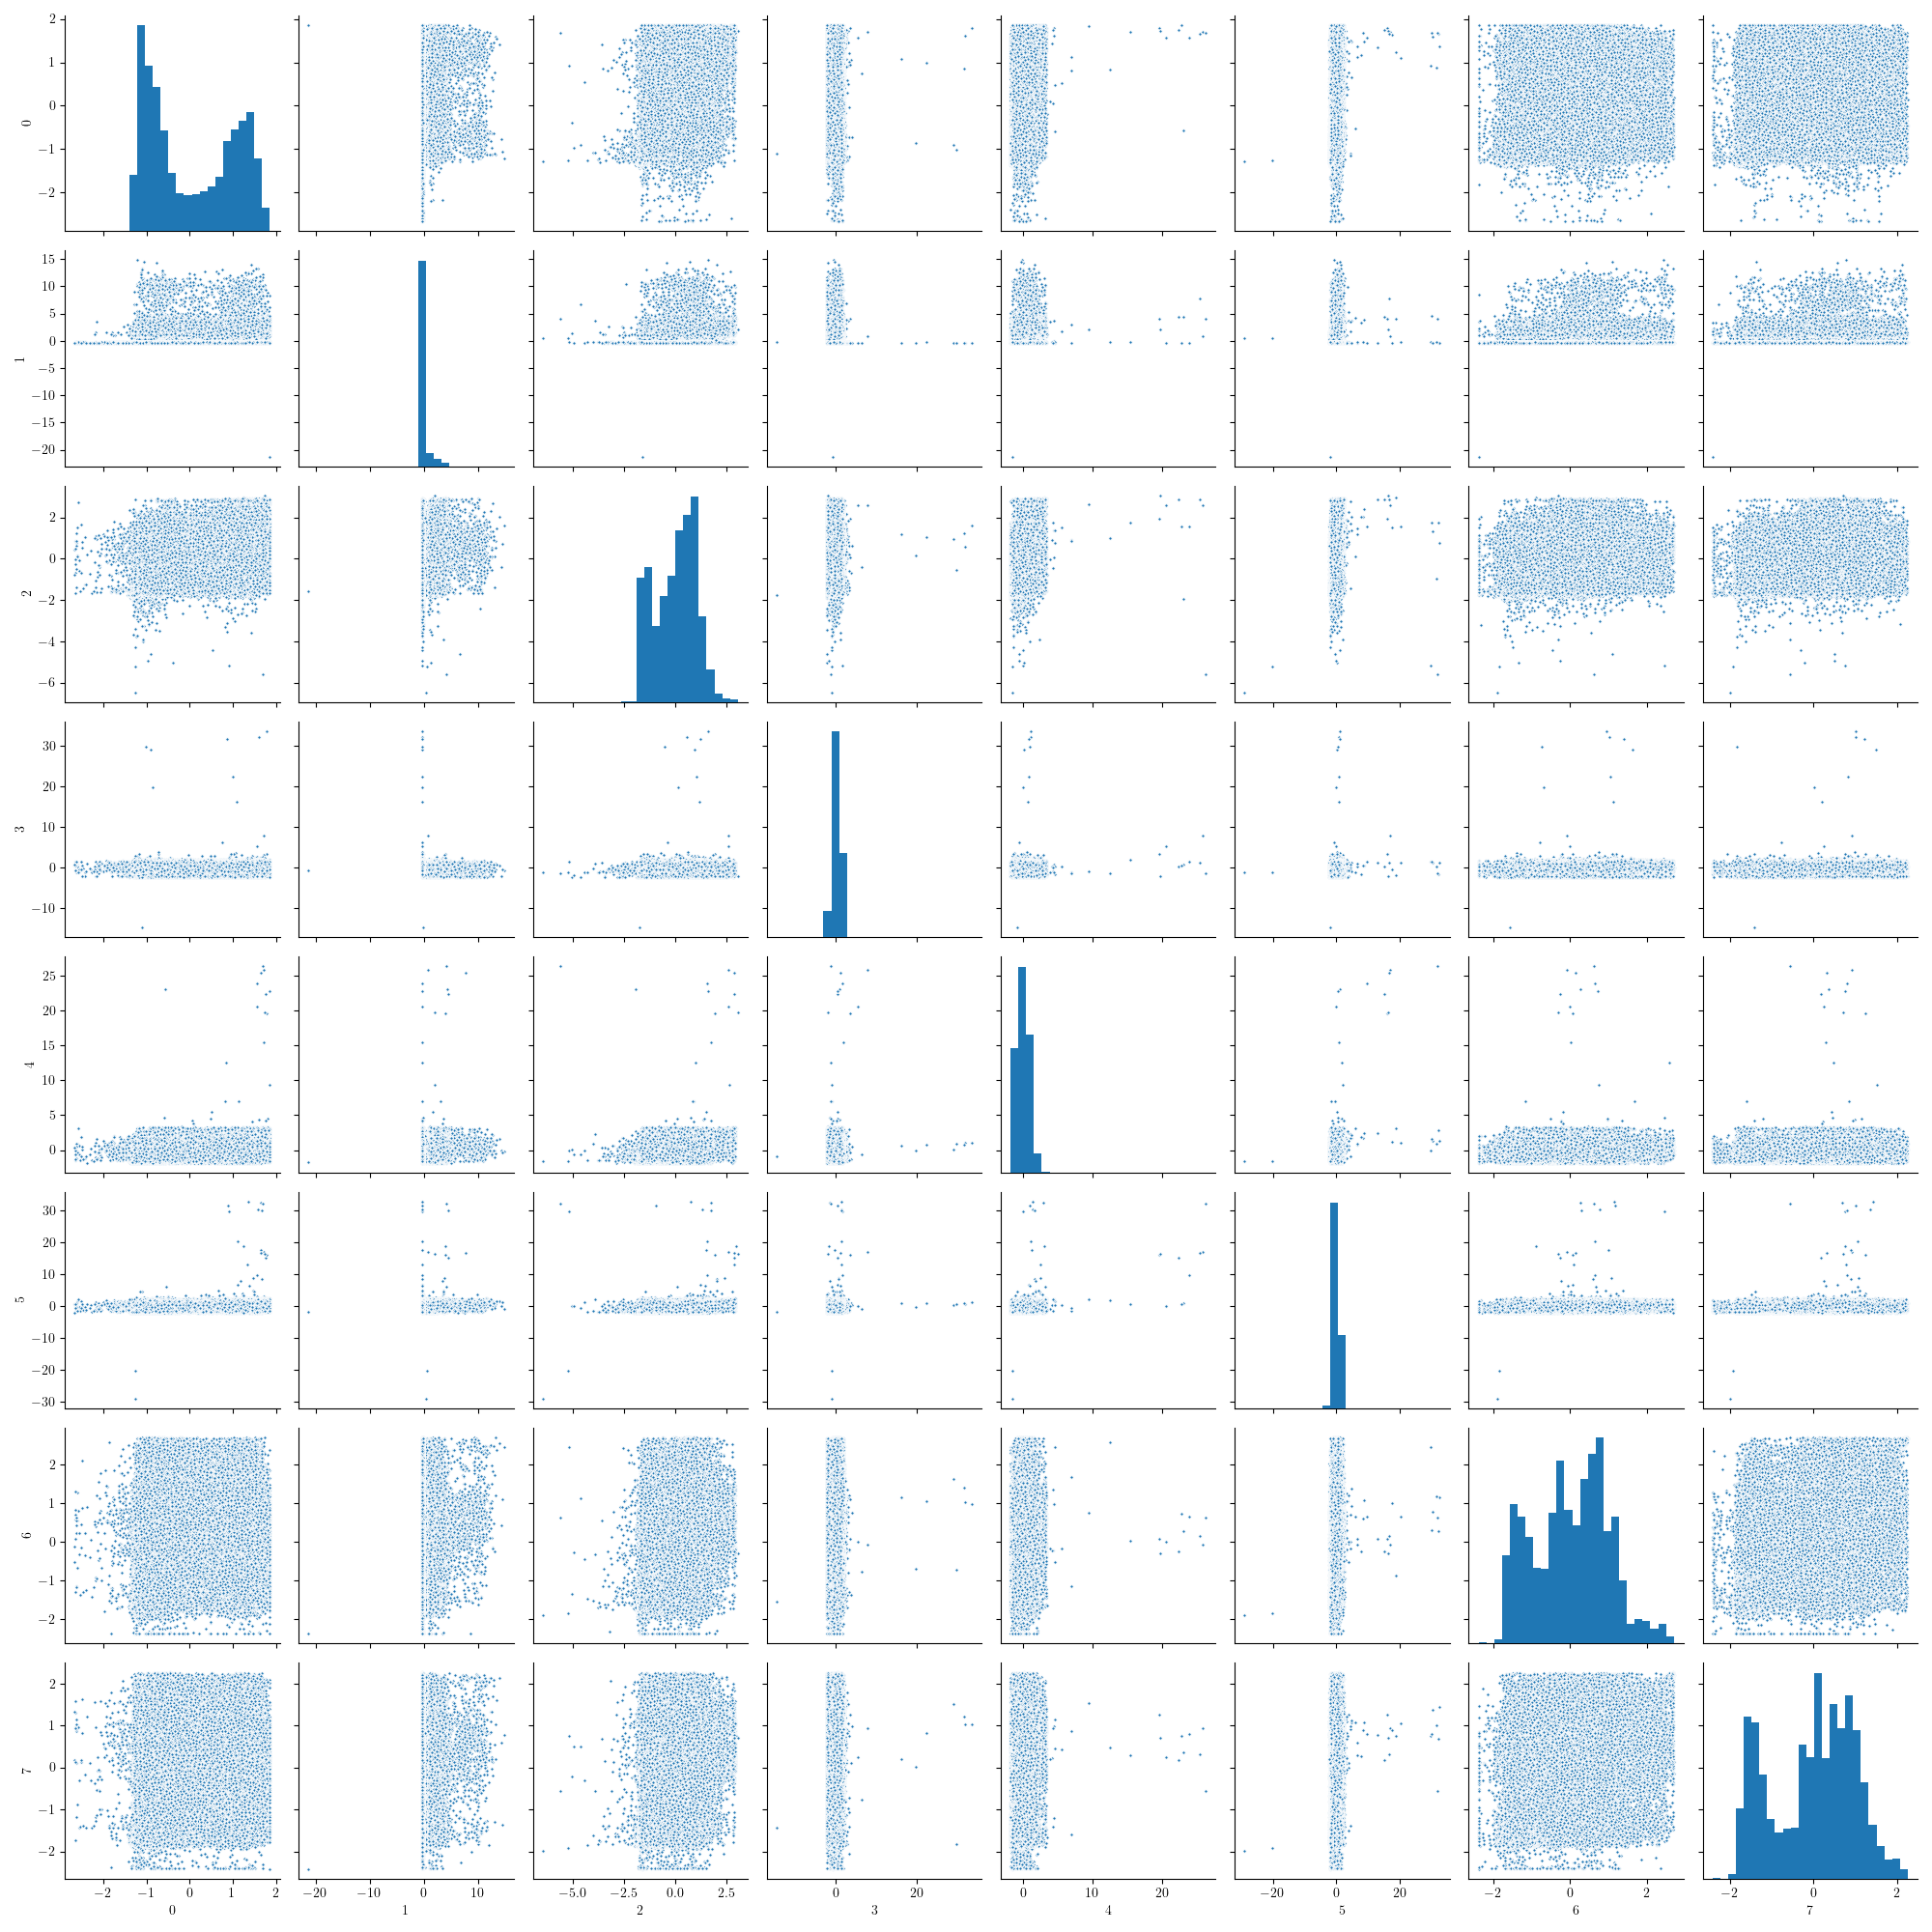

In [23]:
## PLMCMC

group = 1

method = f'rqcspline_{flow_data}_plmcmc'
path = eval_path_template.format(g, 
                                 method, 
                                 exp_seed_keys[0], 
                                 'flow_samples_test.npz')
samples = np.load(path)

sns.pairplot(pd.DataFrame(samples['samples']),
             plot_kws={'s': 6},
             diag_kws={'bins': 25})

plt.tight_layout()
plt.show()


# axes[i].set_title(f'Miss={g/6:.2f}\%, {median=:.2f}, {mean=:.2f}')

# dataset = GasDataset(root='../../data', split='train')

# corrmat = np.corrcoef(dataset.data, rowvar=False)
# abs_corrmat = np.abs(corrmat)
# triang_indices = np.triu_indices_from(corrmat, k=1)
# median = np.median(abs_corrmat[triang_indices])
# mean = np.mean(abs_corrmat[triang_indices])

# cax = axes[-1].matshow(abs_corrmat, interpolation='nearest')

# axes[-1].set_title(f'Original, {median=:.2f}, {mean=:.2f}')  
    
# fig.tight_layout()
# fig.colorbar(cax)


# sns.pairplot(pd.DataFrame(dataset.data),
#              plot_kws={'s': 6},
#              diag_kws={'bins': 25})
# plt.tight_layout()
# plt.draw()

<IPython.core.display.Javascript object>


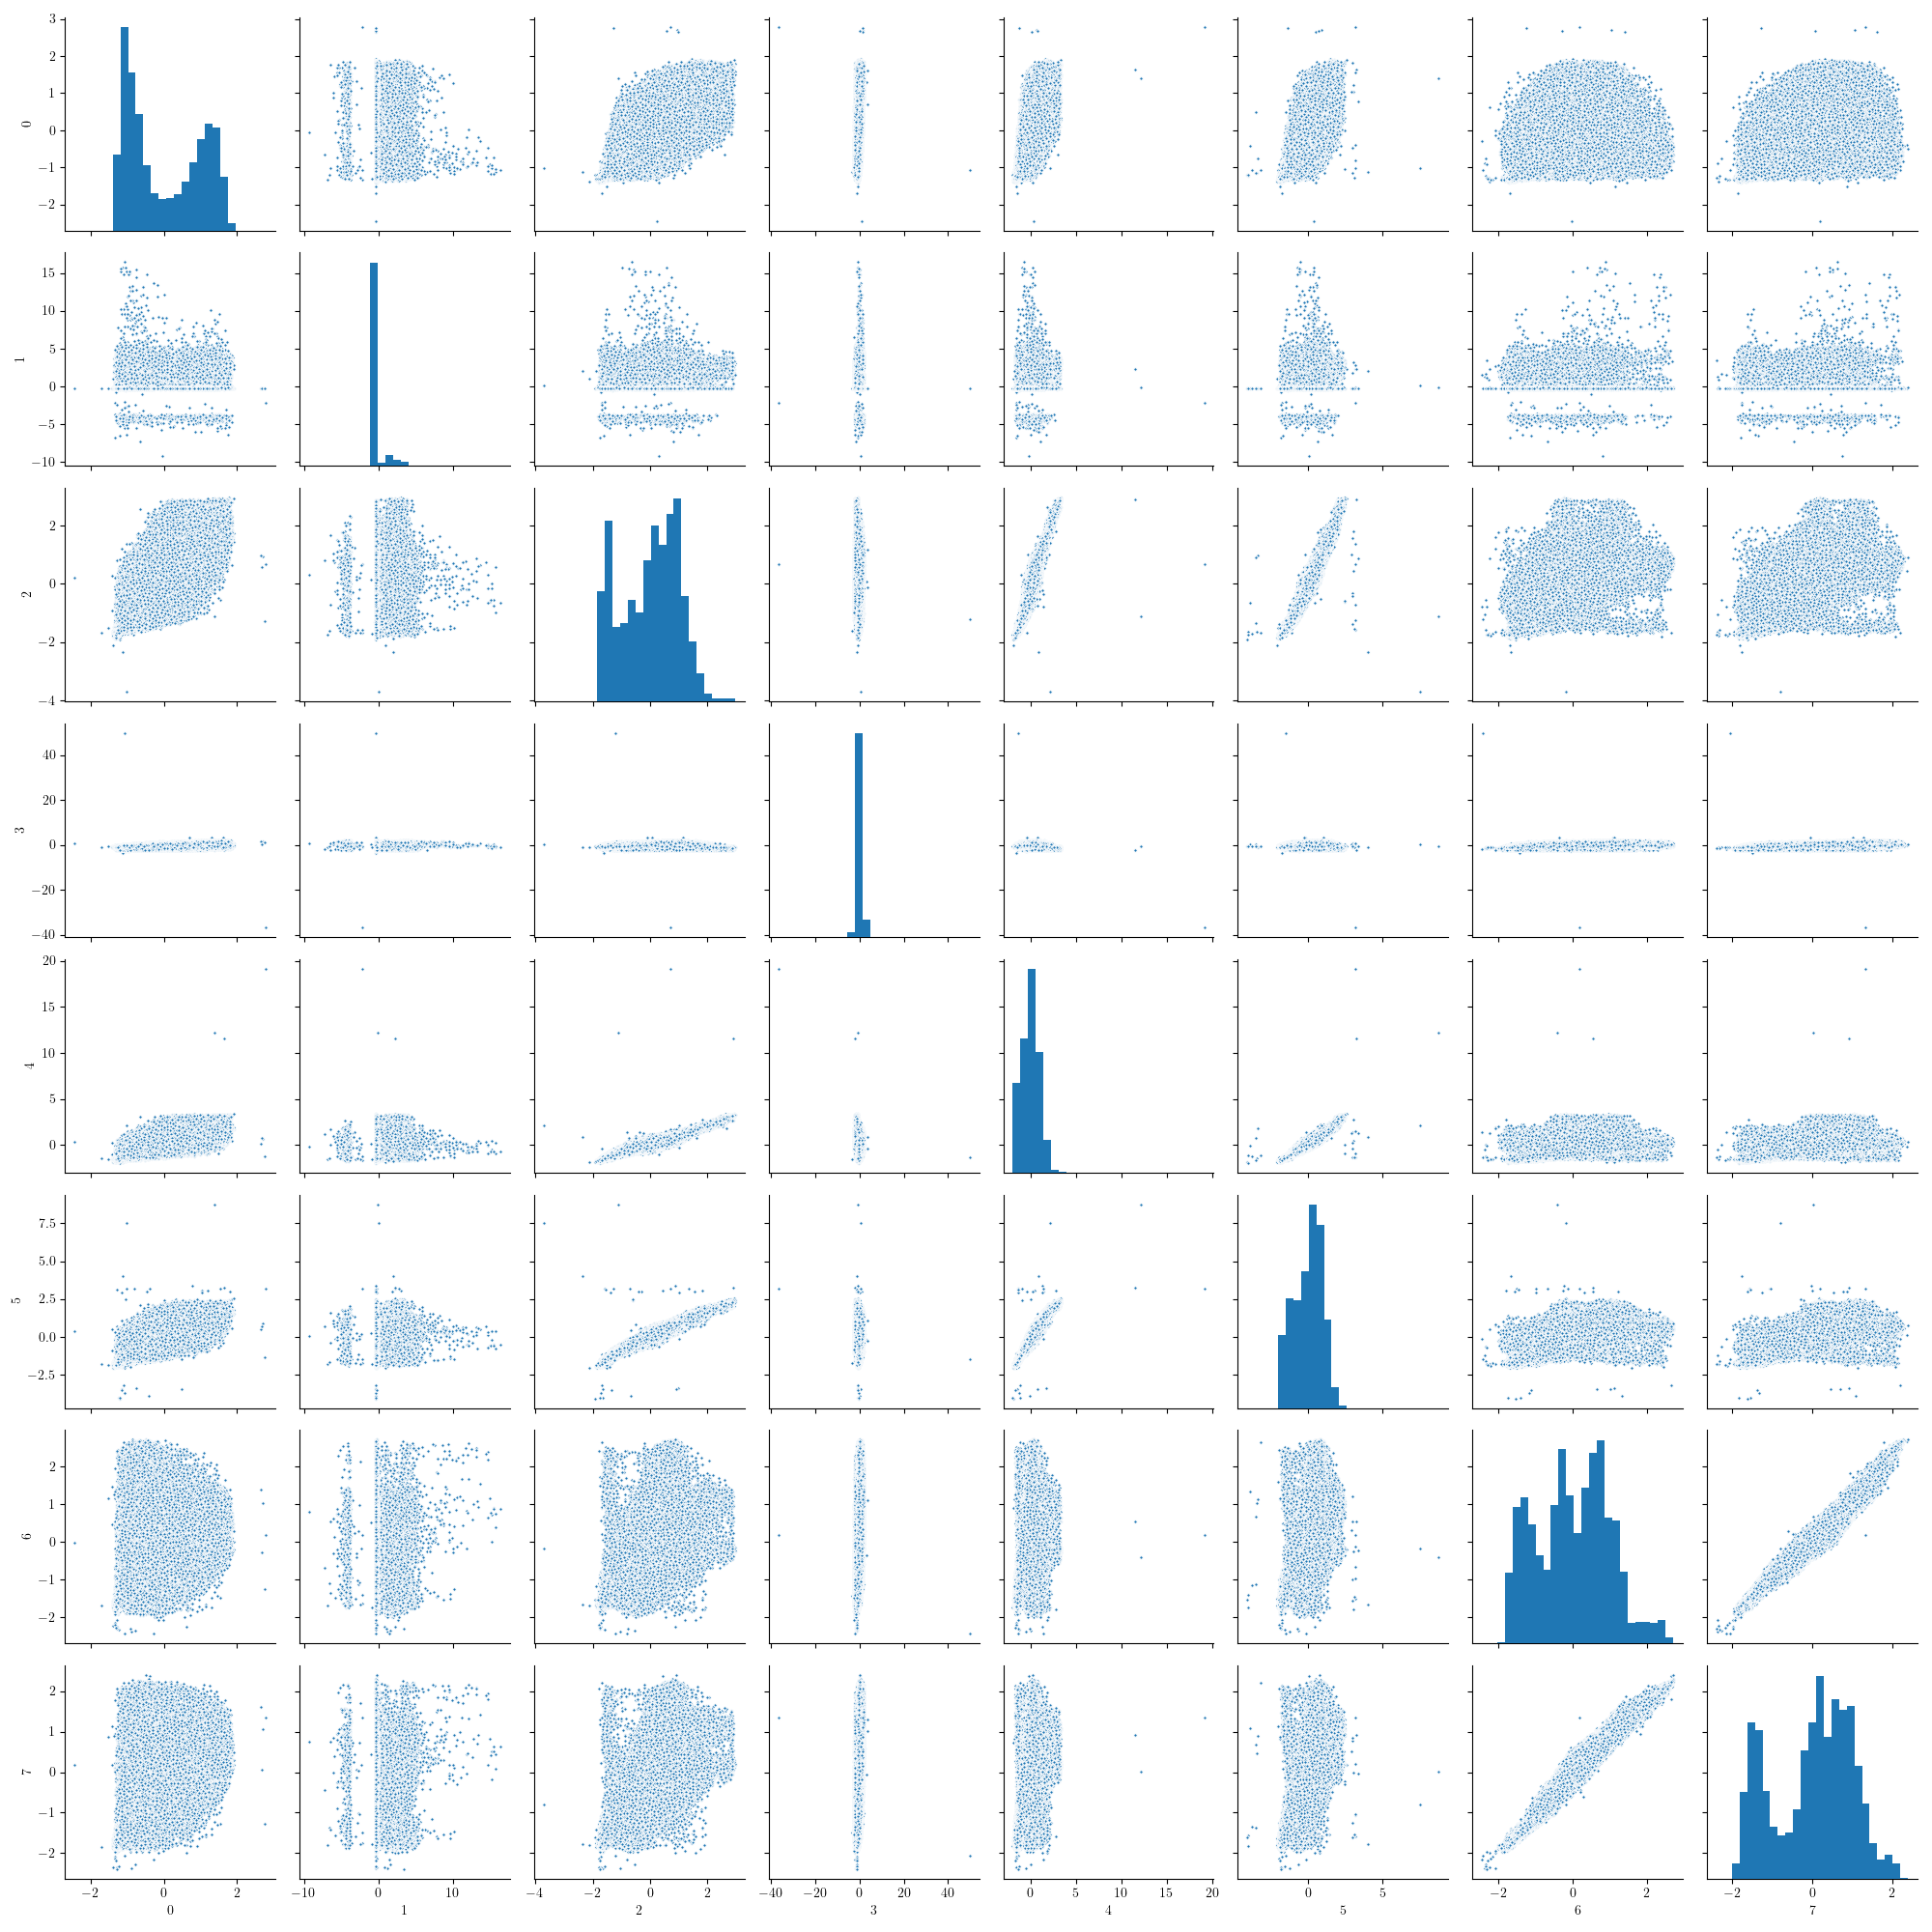

In [28]:
## VGI

group = 1

method = f'rqcspline_{flow_data}_chrqsvar_cdi_uncondgauss'
path = eval_path_template.format(g, 
                                 method, 
                                 exp_seed_keys[0], 
                                 'flow_samples_test.npz')
samples = np.load(path)

sns.pairplot(pd.DataFrame(samples['samples']),
             plot_kws={'s': 6},
             diag_kws={'bins': 25})

plt.tight_layout()
plt.show()


# axes[i].set_title(f'Miss={g/6:.2f}\%, {median=:.2f}, {mean=:.2f}')

# dataset = GasDataset(root='../../data', split='train')

# corrmat = np.corrcoef(dataset.data, rowvar=False)
# abs_corrmat = np.abs(corrmat)
# triang_indices = np.triu_indices_from(corrmat, k=1)
# median = np.median(abs_corrmat[triang_indices])
# mean = np.mean(abs_corrmat[triang_indices])

# cax = axes[-1].matshow(abs_corrmat, interpolation='nearest')

# axes[-1].set_title(f'Original, {median=:.2f}, {mean=:.2f}')  
    
# fig.tight_layout()
# fig.colorbar(cax)


# sns.pairplot(pd.DataFrame(dataset.data),
#              plot_kws={'s': 6},
#              diag_kws={'bins': 25})
# plt.tight_layout()
# plt.draw()

## TODOS

### Test-loglik vs train time

In [28]:
suite = {
#     'Complete MLE (Fitted on original data)': '../../../frey_faces_processed/fcvae_for_synthetic_data/1/fcvae_complete_data',
#     'VAE (Complete)': 'fcvae_complete_data',
    'VGI': 'fcvae_pretrained_svar_cdi_const',
#     'VGI-VAE': 'fcvae_pretrained_svar_cdi_marginalise_k5_const',
    'VBGI-VAE': 'fcvae_mcimp_bvgi2_vardecinputxmask_k5_g1',
    'VBGI-VAE-M': 'fcvae_mcimp_marginalise',
    
#     'MICE': 'fcvae_mice_baseline',
    'MVAE': 'fc_mvae',
#     'HI-VAE': 'fc_hivae',
#     'PartialVAE+': 'fc_pvae_noaggact',
#     'MIWAE': 'fc_miwae',
#     "MIWAE (Complete)": "fc_miwae_complete",
#     "MVAE (Complete)": "fc_mvae_complete"
}

suite_refit = {
    'VGI': 'refitallckpts_fcvae_pretrained_svar_cdi_const',
#     'VGI-VAE': 'refitallckpts_fcvae_pretrained_svar_cdi_marginalise_k5_const',
    'VBGI-VAE': 'refitallckpts_fcvae_mcimp_bvgi2_vardecinputxmask_k5_g1',
    'VBGI-VAE-M': 'refitallckpts_fcvae_mcimp_marginalise',
    
    'MVAE': 'refitallckpts_fc_mvae',
#     'HI-VAE': 'refitallckpts_fc_hivae',
#     'PartialVAE+': 'refitallckpts_fc_pvae_noaggact',
#     'MIWAE': 'refitallckpts_fc_miwae',
}

refit_ckpts = {
    'MIWAE': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'MVAE': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'PartialVAE+': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'HI-VAE': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'VGI': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, 
              5000, 5250, 5500, 5750, 6000, 6250, 6500, 6750,  -1]],
#     'VGI-VAE': [[100, 250, 500, 750, 1000, 1250, 
#               1500, 1750, 2000, 2250, 2500, 2750, -1],
#               [100, 250, 500, 750, 1000, 1250, 
#               1500, 1750, 2000, 2250, 2500, 2750, 3000, 
#               3250, 3500, 3750, -1],
#               [100, 250, 500, 750, 1000, 1250, 
#               1500, 1750, 2000, 2250, 2500, 2750, 3000, 
#               3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
#               [100, 250, 500, 750, 1000, 1250, 
#               1500, 1750, 2000, 2250, 2500, 2750, 3000, 
#               3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
#               [100, 250, 500, 750, 1000, 1250, 
#               1500, 1750, 2000, 2250, 2500, 2750, 3000, 
#               3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'VBGI-VAE': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'VBGI-VAE-M': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
}

<IPython.core.display.Javascript object>


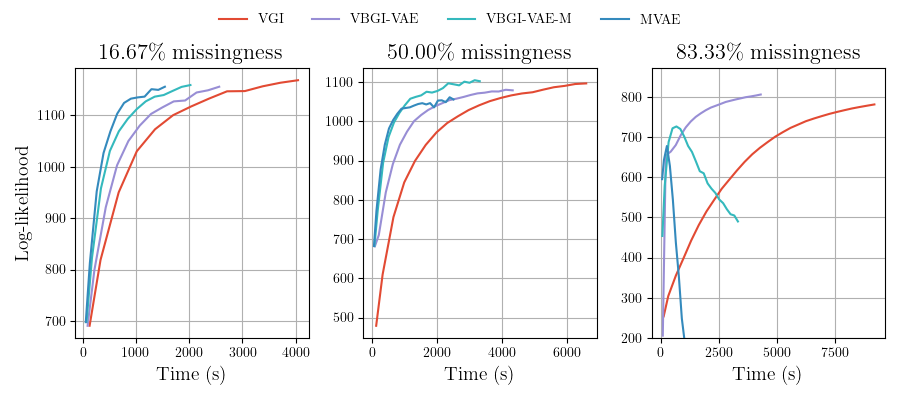

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False, figsize=(9, 4))
axes = axes.flatten()

gs = [1, 3, 5]
ylims = [None, None, (200, None)]
for i, g in enumerate(gs):
    stats = {}
    for exp_name, model_name in suite.items():
        stats[exp_name] = compute_avg_test_loglikelihood_vs_train_time(orig_model=model_name, 
                                                                       refit_model=suite_refit[exp_name],
                                                                       seeds=[exp_seed_keys[0]],
                                                                       ckpts=refit_ckpts[exp_name][g-1],
                                                                       group=g,
                                                                       base_path=log_path_base)

    axes[i].set_title(label=f'{g/6*100:.2f}\% missingness', fontdict={'fontsize': 16})
    if i in (0, ):
        ylabel = 'Log-likelihood'
    else:
        ylabel=None

    xlabel = 'Time (s)'
        
    plot_comparison(axes[i], stats, 
                    x_metric_key='train_time',
#                     y_metric_keys=('train_log_lik', 'val_log_lik'),
#                     err_keys=(None, None,),
                    y_metric_keys=('test_log_lik', ),
                    err_keys=(None, ),
                    xlabel=xlabel,
                    ylabel=ylabel, 
                    ylim=ylims[i],
                    legend=False,
                    colors=colors[1:4]+ colors[5:])

#     axes[i].yaxis.set_visible(False)

fig.tight_layout(rect=(0, 0, 1, 0.93))

# recttuple (left, bottom, right, top)
axes[0].legend(ncol=4, bbox_to_anchor=(0.5, 0.95), bbox_transform=fig.transFigure, loc='center', 
               frameon=False)




In [24]:
# fig.savefig('figures/fcvae_frey_test_loglik_vs_time_selected.pdf', bbox_inches='tight')

### Test-loglik vs train time (all)

In [52]:
suite = {
#     'Complete MLE (Fitted on original data)': '../../../frey_faces_processed/fcvae_for_synthetic_data/1/fcvae_complete_data',
#     'VAE (Complete)': 'fcvae_complete_data',
    'VGI': 'fcvae_pretrained_svar_cdi_const',
#     'VGI-VAE': 'fcvae_pretrained_svar_cdi_marginalise_k5_const',
    'VBGI-VAE': 'fcvae_mcimp_bvgi2_vardecinputxmask_k5_g1',
    'VBGI-VAE-M': 'fcvae_mcimp_marginalise',
    
#     'MICE': 'fcvae_mice_baseline',
    'MVAE': 'fc_mvae',
    'HI-VAE': 'fc_hivae',
    'PartialVAE+': 'fc_pvae_noaggact',
    'MIWAE': 'fc_miwae',
#     "MIWAE (Complete)": "fc_miwae_complete",
#     "MVAE (Complete)": "fc_mvae_complete"
}

suite_refit = {
    'VGI': 'refitallckpts_fcvae_pretrained_svar_cdi_const',
#     'VGI-VAE': 'refitallckpts_fcvae_pretrained_svar_cdi_marginalise_k5_const',
    'VBGI-VAE': 'refitallckpts_fcvae_mcimp_bvgi2_vardecinputxmask_k5_g1',
    'VBGI-VAE-M': 'refitallckpts_fcvae_mcimp_marginalise',
    
    'MVAE': 'refitallckpts_fc_mvae',
    'HI-VAE': 'refitallckpts_fc_hivae',
    'PartialVAE+': 'refitallckpts_fc_pvae_noaggact',
    'MIWAE': 'refitallckpts_fc_miwae',
}

refit_ckpts = {
    'MIWAE': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'MVAE': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'PartialVAE+': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'HI-VAE': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'VGI': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, 
              5000, 5250, 5500, 5750, 6000, 6250, 6500, 6750,  -1]],
#     'VGI-VAE': [[100, 250, 500, 750, 1000, 1250, 
#               1500, 1750, 2000, 2250, 2500, 2750, -1],
#               [100, 250, 500, 750, 1000, 1250, 
#               1500, 1750, 2000, 2250, 2500, 2750, 3000, 
#               3250, 3500, 3750, -1],
#               [100, 250, 500, 750, 1000, 1250, 
#               1500, 1750, 2000, 2250, 2500, 2750, 3000, 
#               3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
#               [100, 250, 500, 750, 1000, 1250, 
#               1500, 1750, 2000, 2250, 2500, 2750, 3000, 
#               3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
#               [100, 250, 500, 750, 1000, 1250, 
#               1500, 1750, 2000, 2250, 2500, 2750, 3000, 
#               3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'VBGI-VAE': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'VBGI-VAE-M': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
}

<IPython.core.display.Javascript object>


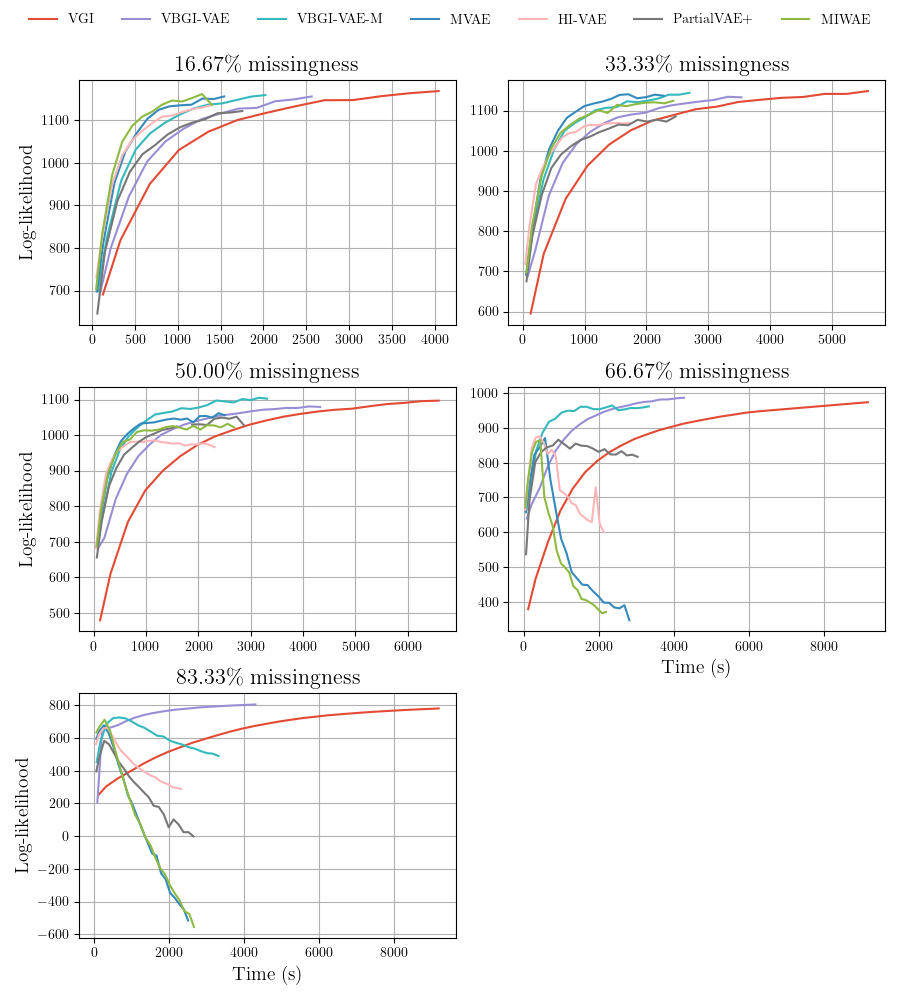

In [54]:
fig, axes = plt.subplots(nrows=3, ncols=2, sharex=False, sharey=False, figsize=(9, 10))
axes = axes.flatten()

# gs = [1, 3, 5]
gs = [1,2,3,4,5]
# ylims = [None, None, (200, None)]
for i, g in enumerate(gs):
    stats = {}
    for exp_name, model_name in suite.items():
        stats[exp_name] = compute_avg_test_loglikelihood_vs_train_time(orig_model=model_name, 
                                                                       refit_model=suite_refit[exp_name],
                                                                       seeds=[exp_seed_keys[0]],
                                                                       ckpts=refit_ckpts[exp_name][g-1],
                                                                       group=g,
                                                                       base_path=log_path_base)

    axes[i].set_title(label=f'{g/6*100:.2f}\% missingness', fontdict={'fontsize': 16})
    
    if i in [0, 2, 4]:
        ylabel = 'Log-likelihood'
    else:
        ylabel = None

    if i in [3, 4]:
        xlabel = 'Time (s)'
    else:
        xlabel = None
        
    plot_comparison(axes[i], stats, 
                    x_metric_key='train_time',
#                     y_metric_keys=('train_log_lik', 'val_log_lik'),
#                     err_keys=(None, None,),
                    y_metric_keys=('test_log_lik', ),
                    err_keys=(None, ),
                    xlabel=xlabel,
                    ylabel=ylabel, 
#                     ylim=ylims[i],
                    legend=False,
                    colors=colors[1:4]+ colors[5:])

    
fig.delaxes(axes[-1])
fig.tight_layout(rect=(0, 0, 1, 0.96))

# recttuple (left, bottom, right, top)
axes[0].legend(ncol=7, bbox_to_anchor=(0.5, 0.98), bbox_transform=fig.transFigure, loc='center', 
               frameon=False)

In [55]:
# fig.savefig('figures/fcvae_frey_test_loglik_vs_time_all.pdf', bbox_inches='tight')

### Test-loglik vs train epoch vs train time

In [58]:
suite = {
#     'Complete MLE (Fitted on original data)': '../../../frey_faces_processed/fcvae_for_synthetic_data/1/fcvae_complete_data',
#     'VAE (Complete)': 'fcvae_complete_data',
    'VGI': 'fcvae_pretrained_svar_cdi_const',
#     'VGI-VAE': 'fcvae_pretrained_svar_cdi_marginalise_k5_const',
    'VBGI-VAE': 'fcvae_mcimp_bvgi2_vardecinputxmask_k5_g1',
    'VBGI-VAE-M': 'fcvae_mcimp_marginalise',
    
#     'MICE': 'fcvae_mice_baseline',
    'MVAE': 'fc_mvae',
#     'HI-VAE': 'fc_hivae',
#     'PartialVAE+': 'fc_pvae_noaggact',
#     'MIWAE': 'fc_miwae',
#     "MIWAE (Complete)": "fc_miwae_complete",
#     "MVAE (Complete)": "fc_mvae_complete"
}

suite_refit = {
    'VGI': 'refitallckpts_fcvae_pretrained_svar_cdi_const',
#     'VGI-VAE': 'refitallckpts_fcvae_pretrained_svar_cdi_marginalise_k5_const',
    'VBGI-VAE': 'refitallckpts_fcvae_mcimp_bvgi2_vardecinputxmask_k5_g1',
    'VBGI-VAE-M': 'refitallckpts_fcvae_mcimp_marginalise',
    
    'MVAE': 'refitallckpts_fc_mvae',
#     'HI-VAE': 'refitallckpts_fc_hivae',
#     'PartialVAE+': 'refitallckpts_fc_pvae_noaggact',
#     'MIWAE': 'refitallckpts_fc_miwae',
}

refit_ckpts = {
    'MIWAE': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'MVAE': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'PartialVAE+': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'HI-VAE': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'VGI': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, 
              5000, 5250, 5500, 5750, 6000, 6250, 6500, 6750,  -1]],
#     'VGI-VAE': [[100, 250, 500, 750, 1000, 1250, 
#               1500, 1750, 2000, 2250, 2500, 2750, -1],
#               [100, 250, 500, 750, 1000, 1250, 
#               1500, 1750, 2000, 2250, 2500, 2750, 3000, 
#               3250, 3500, 3750, -1],
#               [100, 250, 500, 750, 1000, 1250, 
#               1500, 1750, 2000, 2250, 2500, 2750, 3000, 
#               3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
#               [100, 250, 500, 750, 1000, 1250, 
#               1500, 1750, 2000, 2250, 2500, 2750, 3000, 
#               3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
#               [100, 250, 500, 750, 1000, 1250, 
#               1500, 1750, 2000, 2250, 2500, 2750, 3000, 
#               3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'VBGI-VAE': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'VBGI-VAE-M': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
}

<IPython.core.display.Javascript object>


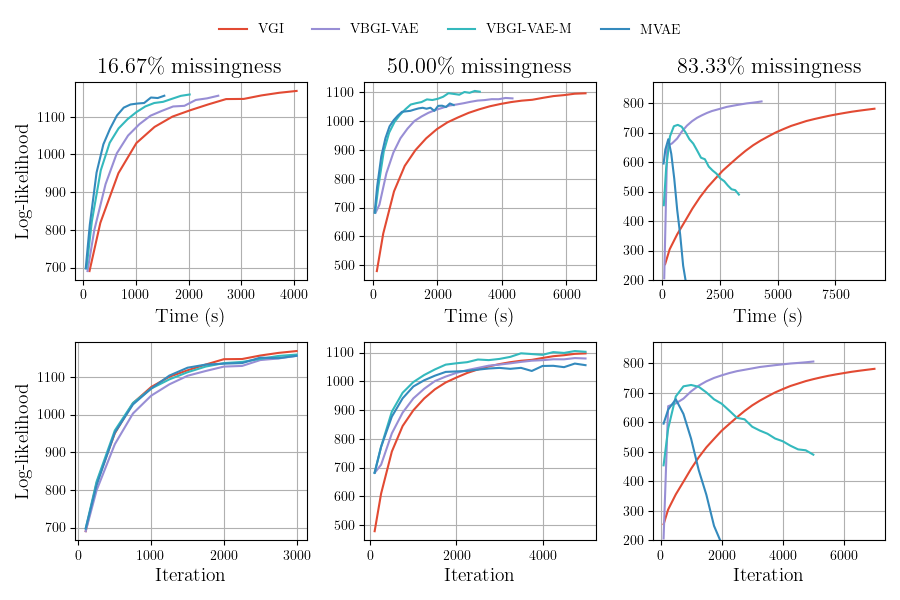

In [60]:
fig, axes = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False, figsize=(9, 6))
axes = axes.flatten()

gs = [1, 3, 5]
ylims = [None, None, (200, None)]
for i, g in enumerate(gs):
    stats = {}
    for exp_name, model_name in suite.items():
        stats[exp_name] = compute_avg_test_loglikelihood_vs_train_time(orig_model=model_name, 
                                                                       refit_model=suite_refit[exp_name],
                                                                       seeds=[exp_seed_keys[0]],
                                                                       ckpts=refit_ckpts[exp_name][g-1],
                                                                       group=g,
                                                                       base_path=log_path_base)

    axes[i].set_title(label=f'{g/6*100:.2f}\% missingness', fontdict={'fontsize': 16})
    if i in (0, ):
        ylabel = 'Log-likelihood'
    else:
        ylabel=None

    xlabel = 'Time (s)'
        
    plot_comparison(axes[i], stats, 
                    x_metric_key='train_time',
#                     y_metric_keys=('train_log_lik', 'val_log_lik'),
#                     err_keys=(None, None,),
                    y_metric_keys=('test_log_lik', ),
                    err_keys=(None, ),
                    xlabel=xlabel,
                    ylabel=ylabel, 
                    ylim=ylims[i],
                    legend=False,
                    colors=colors[1:4]+ colors[5:])
    
    xlabel = 'Iteration'
    
    plot_comparison(axes[i+len(gs)], stats, 
                    x_metric_key='epoch',
#                     y_metric_keys=('train_log_lik', 'val_log_lik'),
#                     err_keys=(None, None,),
                    y_metric_keys=('test_log_lik', ),
                    err_keys=(None, ),
                    xlabel=xlabel,
                    ylabel=ylabel, 
                    ylim=ylims[i],
                    legend=False,
                    colors=colors[1:4]+ colors[5:])

#     axes[i].yaxis.set_visible(False)

fig.tight_layout(rect=(0, 0, 1, 0.93))

# recttuple (left, bottom, right, top)
axes[0].legend(ncol=4, bbox_to_anchor=(0.5, 0.95), bbox_transform=fig.transFigure, loc='center', 
               frameon=False)




### Test-loglik vs train epoch

In [66]:
suite = {
#     'Complete MLE (Fitted on original data)': '../../../frey_faces_processed/fcvae_for_synthetic_data/1/fcvae_complete_data',
#     'VAE (Complete)': 'fcvae_complete_data',
    'VGI': 'fcvae_pretrained_svar_cdi_const',
#     'VGI-VAE': 'fcvae_pretrained_svar_cdi_marginalise_k5_const',
    'VBGI-VAE': 'fcvae_mcimp_bvgi2_vardecinputxmask_k5_g1',
    'VBGI-VAE-M': 'fcvae_mcimp_marginalise',
    
#     'MICE': 'fcvae_mice_baseline',
    'MVAE': 'fc_mvae',
#     'HI-VAE': 'fc_hivae',
#     'PartialVAE+': 'fc_pvae_noaggact',
#     'MIWAE': 'fc_miwae',
#     "MIWAE (Complete)": "fc_miwae_complete",
#     "MVAE (Complete)": "fc_mvae_complete"
}

suite_refit = {
    'VGI': 'refitallckpts_fcvae_pretrained_svar_cdi_const',
#     'VGI-VAE': 'refitallckpts_fcvae_pretrained_svar_cdi_marginalise_k5_const',
    'VBGI-VAE': 'refitallckpts_fcvae_mcimp_bvgi2_vardecinputxmask_k5_g1',
    'VBGI-VAE-M': 'refitallckpts_fcvae_mcimp_marginalise',
    
    'MVAE': 'refitallckpts_fc_mvae',
#     'HI-VAE': 'refitallckpts_fc_hivae',
#     'PartialVAE+': 'refitallckpts_fc_pvae_noaggact',
#     'MIWAE': 'refitallckpts_fc_miwae',
}

refit_ckpts = {
    'MIWAE': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'MVAE': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'PartialVAE+': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'HI-VAE': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'VGI': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, 
              5000, 5250, 5500, 5750, 6000, 6250, 6500, 6750,  -1]],
#     'VGI-VAE': [[100, 250, 500, 750, 1000, 1250, 
#               1500, 1750, 2000, 2250, 2500, 2750, -1],
#               [100, 250, 500, 750, 1000, 1250, 
#               1500, 1750, 2000, 2250, 2500, 2750, 3000, 
#               3250, 3500, 3750, -1],
#               [100, 250, 500, 750, 1000, 1250, 
#               1500, 1750, 2000, 2250, 2500, 2750, 3000, 
#               3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
#               [100, 250, 500, 750, 1000, 1250, 
#               1500, 1750, 2000, 2250, 2500, 2750, 3000, 
#               3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
#               [100, 250, 500, 750, 1000, 1250, 
#               1500, 1750, 2000, 2250, 2500, 2750, 3000, 
#               3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'VBGI-VAE': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'VBGI-VAE-M': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
}

<IPython.core.display.Javascript object>


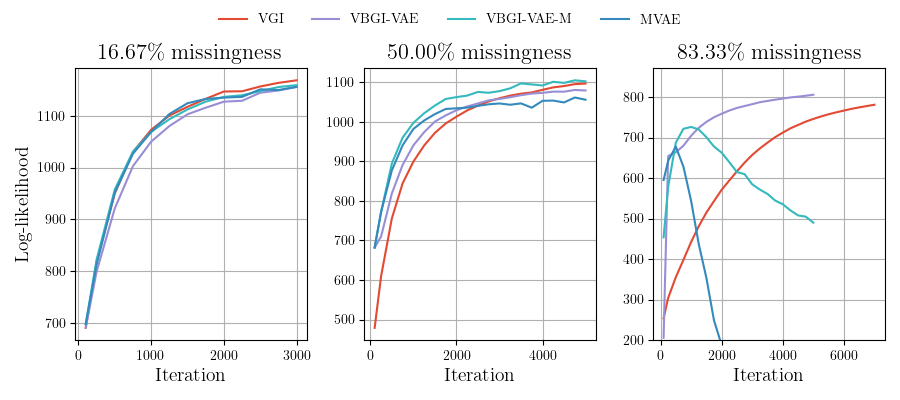

In [69]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False, figsize=(9, 4))
axes = axes.flatten()

gs = [1, 3, 5]
ylims = [None, None, (200, None)]
for i, g in enumerate(gs):
    stats = {}
    for exp_name, model_name in suite.items():
        stats[exp_name] = compute_avg_test_loglikelihood_vs_train_time(orig_model=model_name, 
                                                                       refit_model=suite_refit[exp_name],
                                                                       seeds=[exp_seed_keys[0]],
                                                                       ckpts=refit_ckpts[exp_name][g-1],
                                                                       group=g,
                                                                       base_path=log_path_base)

    axes[i].set_title(label=f'{g/6*100:.2f}\% missingness', fontdict={'fontsize': 16})
    if i in (0, ):
        ylabel = 'Log-likelihood'
    else:
        ylabel=None

    xlabel = 'Iteration'
        
    plot_comparison(axes[i], stats, 
                    x_metric_key='epoch',
#                     y_metric_keys=('train_log_lik', 'val_log_lik'),
#                     err_keys=(None, None,),
                    y_metric_keys=('test_log_lik', ),
                    err_keys=(None, ),
                    xlabel=xlabel,
                    ylabel=ylabel, 
                    ylim=ylims[i],
                    legend=False,
                    colors=colors[1:4]+ colors[5:])

#     axes[i].yaxis.set_visible(False)

fig.tight_layout(rect=(0, 0, 1, 0.93))

# recttuple (left, bottom, right, top)
axes[0].legend(ncol=4, bbox_to_anchor=(0.5, 0.95), bbox_transform=fig.transFigure, loc='center', 
               frameon=False)




In [70]:
# fig.savefig('figures/fcvae_frey_test_loglik_vs_epoch_selected.pdf', bbox_inches='tight')

### Test-loglik vs train epoch and avg train iteration time

In [90]:
suite = {
#     'Complete MLE (Fitted on original data)': '../../../frey_faces_processed/fcvae_for_synthetic_data/1/fcvae_complete_data',
#     'VAE (Complete)': 'fcvae_complete_data',
    'VGI': 'fcvae_pretrained_svar_cdi_const',
#     'VGI-VAE': 'fcvae_pretrained_svar_cdi_marginalise_k5_const',
    'VBGI-VAE': 'fcvae_mcimp_bvgi2_vardecinputxmask_k5_g1',
    'VBGI-VAE-M': 'fcvae_mcimp_marginalise',
    
#     'MICE': 'fcvae_mice_baseline',
    'MVAE': 'fc_mvae',
#     'HI-VAE': 'fc_hivae',
#     'PartialVAE+': 'fc_pvae_noaggact',
#     'MIWAE': 'fc_miwae',
#     "MIWAE (Complete)": "fc_miwae_complete",
#     "MVAE (Complete)": "fc_mvae_complete"
}

suite_refit = {
    'VGI': 'refitallckpts_fcvae_pretrained_svar_cdi_const',
#     'VGI-VAE': 'refitallckpts_fcvae_pretrained_svar_cdi_marginalise_k5_const',
    'VBGI-VAE': 'refitallckpts_fcvae_mcimp_bvgi2_vardecinputxmask_k5_g1',
    'VBGI-VAE-M': 'refitallckpts_fcvae_mcimp_marginalise',
    
    'MVAE': 'refitallckpts_fc_mvae',
#     'HI-VAE': 'refitallckpts_fc_hivae',
#     'PartialVAE+': 'refitallckpts_fc_pvae_noaggact',
#     'MIWAE': 'refitallckpts_fc_miwae',
}

refit_ckpts = {
    'MIWAE': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'MVAE': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'PartialVAE+': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'HI-VAE': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'VGI': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, 
              5000, 5250, 5500, 5750, 6000, 6250, 6500, 6750,  -1]],
#     'VGI-VAE': [[100, 250, 500, 750, 1000, 1250, 
#               1500, 1750, 2000, 2250, 2500, 2750, -1],
#               [100, 250, 500, 750, 1000, 1250, 
#               1500, 1750, 2000, 2250, 2500, 2750, 3000, 
#               3250, 3500, 3750, -1],
#               [100, 250, 500, 750, 1000, 1250, 
#               1500, 1750, 2000, 2250, 2500, 2750, 3000, 
#               3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
#               [100, 250, 500, 750, 1000, 1250, 
#               1500, 1750, 2000, 2250, 2500, 2750, 3000, 
#               3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
#               [100, 250, 500, 750, 1000, 1250, 
#               1500, 1750, 2000, 2250, 2500, 2750, 3000, 
#               3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'VBGI-VAE': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'VBGI-VAE-M': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
}

imp_time_suite = {
    'VGI': 'fcvae_pretrained_svar_cdi_const_time',
#     'VGI-VAE': 'fcvae_pretrained_svar_cdi_marginalise_k5_const_time',
    'VBGI-VAE': 'fcvae_mcimp_bvgi2_vardecinputxmask_k5_g1',
    'VBGI-VAE-M': 'fcvae_mcimp_marginalise', 
}

final_epochs = {
    'VGI': ['last', 'last', 'last', 'last', 'last'],
#     'VGI-VAE': ['last', 'last', 'last', 2750, 1000],
    'VBGI-VAE': ['last', 'last', 'last', 'last', 'last'],
    'VBGI-VAE-M': ['last', 'last', 'last', 'last', 1000],
    
    'MVAE': ['last', 'last', 'last', 1000, 500],
    'HI-VAE': ['last', 'last', 'last', 1000, 500],
    'PartialVAE+': ['last', 'last', 'last', 1500, 500],
    'MIWAE': ['last', 'last', 'last', 1000, 500],
}

<IPython.core.display.Javascript object>


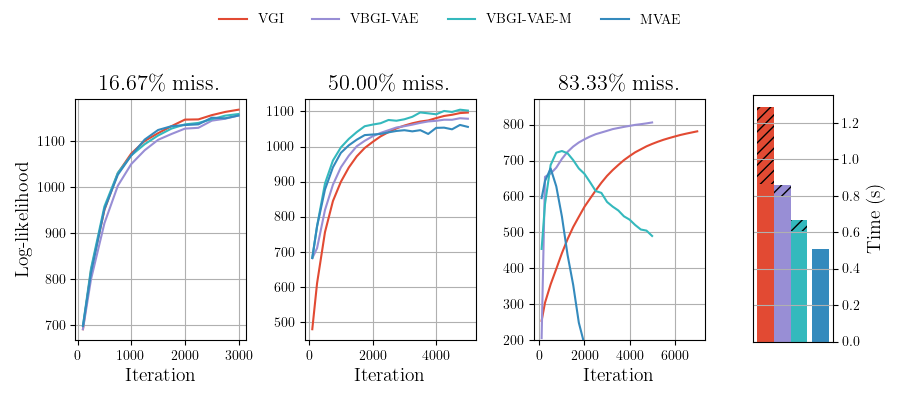

<ipython-input-130-dffc4ac6b769>:153: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  gs1.tight_layout(fig, rect=[0, 0, 0.8, 0.85])  #top=0.85, left=0.08, right=0.80
<ipython-input-130-dffc4ac6b769>:154: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  gs2.tight_layout(fig, rect=[0.82, 0.09, 1, 0.8])  #to/p=0.85, left=0.82, right=0.92


In [130]:
# fig, axes = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False, figsize=(9, 4))
# axes = axes.flatten()
fig = plt.figure(constrained_layout=False, figsize=(9, 4))
# gridspec = fig.add_gridspec(1, 11)
gs1 = fig.add_gridspec(nrows=1, ncols=3, top=0.85, right=0.80)
gs2 = fig.add_gridspec(nrows=1, ncols=1, top=0.85, left=0.82)

axes = []
axes.append(fig.add_subplot(gs1[0]))
axes.append(fig.add_subplot(gs1[1]))
axes.append(fig.add_subplot(gs1[2]))
axes.append(fig.add_subplot(gs2[0]))

gs = [1, 3, 5]
ylims = [None, None, (200, None)]
time_stats = defaultdict(lambda: defaultdict(list))
for i, g in enumerate(gs):
    stats = {}
    for exp_name, model_name in suite.items():
        stats[exp_name] = compute_avg_test_loglikelihood_vs_train_time(orig_model=model_name, 
                                                                       refit_model=suite_refit[exp_name],
                                                                       seeds=[exp_seed_keys[0]],
                                                                       ckpts=refit_ckpts[exp_name][g-1],
                                                                       group=g,
                                                                       base_path=log_path_base)
#         time_stats[exp_name]['time_per_epoch'].append(stats[exp_name]['train_time'][-1]/stats[exp_name]['epoch'][-1])
#         time_stats[exp_name]['imp_time_per_epoch'].append(stats[exp_name]['train_imp_time'][-1]/stats[exp_name]['epoch'][-1])

    axes[i].set_title(label=f'{g/6*100:.2f}\% miss.', fontdict={'fontsize': 16})
    if i in (0, ):
        ylabel = 'Log-likelihood'
    else:
        ylabel=None

    xlabel = 'Iteration'
        
    plot_comparison(axes[i], stats, 
                    x_metric_key='epoch',
#                     y_metric_keys=('train_log_lik', 'val_log_lik'),
#                     err_keys=(None, None,),
                    y_metric_keys=('test_log_lik', ),
                    err_keys=(None, ),
                    xlabel=xlabel,
                    ylabel=ylabel, 
                    ylim=ylims[i],
                    legend=False,
                    colors=colors[1:4]+ colors[5:])

# Time plot
    
stats = defaultdict(lambda: defaultdict(list))
for i, g in enumerate(gs):
    stats_g = read_suite_stats_with_init_all_seeds(group=g, suite=suite)
    for m in suite.keys():
        # add padding for other methods
        if m in imp_time_suite:
            stats[m]['train_time'].append(0)
            stats[m]['group'].append(g)
        else:
            s = stats_g[m]
#             if final_epochs[m][g-1] == 'last':
#                 time = np.mean(s['train_time'], axis=1)
#             else:
                # If we early-stopping, count time until stopped
#                 time = np.mean(np.array(s['train_time'])[:, :final_epochs[m][g-1]], axis=1)
            time = np.mean(np.array(s['train_time']), axis=1)

            stats[m]['train_time'].append(time.mean())
            stats[m]['group'].append(g)

for m, s in stats.items():
    stats[m]['train_time'] = [np.mean(stats[m]['train_time'])]
    stats[m]['dummy'] = [1]

# Imputation time in VGI methods
imp_stats = defaultdict(lambda: defaultdict(list))
for i, g in enumerate(gs):
    stats_g = read_suite_stats_with_init(group=g, suite=imp_time_suite, seed=exp_seed_keys[0])
    for m in suite.keys():
        # add padding for other methods
        if m not in imp_time_suite:
            imp_stats[m]['train_time_minus_imp_time'].append(0)
            imp_stats[m]['group'].append(g)
        else:
            s = stats_g[m]
#             if final_epochs[m][g-1] == 'last':
#                 imp_time = np.array(s['train_imp_time'])
#                 train_time = np.array(s['train_time'])
#                 time = train_time - imp_time
#             else:
#                 # If we early-stopping, count time until stopped
#                 imp_time = np.array(s['train_imp_time'])[:final_epochs[m][g-1]]
#                 train_time = np.array(s['train_time'])[:final_epochs[m][g-1]]
#                 time = train_time - imp_time
            imp_time = np.array(s['train_imp_time'])
            train_time = np.array(s['train_time'])
            time = train_time - imp_time

            imp_stats[m]['train_time_minus_imp_time'].append(np.mean(time))
            imp_stats[m]['train_time'].append(np.mean(train_time))
            imp_stats[m]['train_imp_time'].append(np.mean(imp_time))
            imp_stats[m]['group'].append(g)

for m, s in imp_stats.items():
    imp_stats[m]['train_imp_time'] = [np.mean(imp_stats[m]['train_imp_time'])]
    imp_stats[m]['train_time_minus_imp_time'] = [np.mean(imp_stats[m]['train_time_minus_imp_time'])]
    imp_stats[m]['dummy'] = [1]
            

barplot_comparison(axes[-1], imp_stats, width=0.11,
                   gap=0.03, gap_idxs=[2],
                    x_metric_key='dummy',
                    y_metric_keys=('train_imp_time',),  
                    err_keys=(None,),
                    y_bott_keys=('train_time_minus_imp_time',),
                    xlabel='Missingness',
                    ylabel='Time (s)', 
                    colors=colors[1:4] + colors[5:],
                    hatches=['///']*3 + [None]*4,
                    alpha=0.999,  # Workaround for hatches disappearing when rendering to pdf
                   legend=False
                  )
    
barplot_comparison(axes[-1], imp_stats, width=0.11,
                   gap=0.03, gap_idxs=[2],
                    x_metric_key='dummy',
                    y_metric_keys=('train_time_minus_imp_time',),  
                    err_keys=(None,),
                    xlabel=None,
                    ylabel=None, 
                    colors=colors[1:4] + colors[5:],
                   legend=False
                  )

barplot_comparison(axes[-1], stats, width=0.11,
                   gap=0.03, gap_idxs=[2],
                    x_metric_key='dummy',
                    y_metric_keys=('train_time',),  
                    err_keys=(None,),
                    xlabel=None,
                    ylabel='Time (s)', 
                    colors=colors[1:4] + colors[5:],
#                     hatches=['///']*2 + [None]*4,
                   legend=False
                  )

axes[-1].yaxis.tick_right()
axes[-1].yaxis.set_label_position("right")
axes[-1].set_xticks([])
# axes[-1].grid()

# fig.tight_layout(rect=(0, 0, 1, 0.80))
gs1.tight_layout(fig, rect=[0, 0, 0.8, 0.85])
gs2.tight_layout(fig, rect=[0.82, 0.1, 1, 0.8])

# recttuple (left, bottom, right, top)
axes[0].legend(ncol=4, bbox_to_anchor=(0.5, 0.95), bbox_transform=fig.transFigure, loc='center', 
               frameon=False)


